#### Natural Disaster Natural Language Processing

In [94]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout, Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM, Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### EDA

In [95]:
train = pd.read_csv('m9_train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [96]:
test = pd.read_csv('m9_test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [97]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [98]:
print(train.describe)

<bound method NDFrame.describe of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w.

In [99]:
train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
id             0
text           0
target         0
dtype: int64

In [100]:
#lets save stopwords in a variable
stop = list(stopwords.words("english"))

# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)

# create an object to convert the words to its lemma form
lemma = WordNetLemmatizer()

# lets make a combine list of stopwords and punctuations
sw_pun = stop + punctuation

In [101]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

# apply preprocessing functions on the train and test datasets
train['text'] = train['text'].apply(lambda s : preprocess(s))
test['text'] = test ['text'].apply(lambda s : preprocess(s))

In [102]:
# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

  # applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test ['text'] = test ['text'].apply(lambda s : remove_emoji(s))

#### Vocabulary Analysis

In [103]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)

In [131]:
# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
print(f'Length of vocab: {len(vocab)}')

# lets check the most common 50 words in the vocabulary
print('\nThese are the 50 most common words:')
vocab.most_common(50)

Length of vocab: 16442

These are the 50 most common words:


[('like', 560),
 ('fire', 534),
 ('bomb', 338),
 ('news', 299),
 ('people', 286),
 ('burn', 262),
 ('time', 254),
 ('kill', 253),
 ('make', 248),
 ('attack', 240),
 ('flood', 233),
 ('crash', 232),
 ('build', 231),
 ('emergency', 229),
 ('video', 228),
 ('come', 223),
 ('disaster', 220),
 ('take', 217),
 ('would', 214),
 ('body', 209),
 ('think', 204),
 ('police', 199),
 ('look', 193),
 ('know', 192),
 ('love', 190),
 ('watch', 188),
 ('home', 187),
 ('storm', 187),
 ('still', 181),
 ('train', 177),
 ('suicide', 177),
 ('live', 172),
 ('first', 170),
 ('collapse', 169),
 ('back', 164),
 ('scream', 164),
 ('california', 159),
 ('want', 156),
 ('drown', 152),
 ('cause', 151),
 ('need', 150),
 ('work', 149),
 ('today', 149),
 ('world', 148),
 ('nuclear', 148),
 ('hiroshima', 147),
 ('year', 143),
 ('full', 143),
 ('service', 142),
 ('destroy', 138)]

In [135]:
# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [136]:
# lets check the no. of the words in the final vocabulary
vocab_size = len(final_vocab)
vocab_size

6025

In [137]:
# function to filter the dataset, keep only words which are present in the vocab
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

# apply filter function on the train and test datasets
train['text'] = train['text'].apply(lambda s : filter(s))
test ['text'] = test ['text'].apply(lambda s : filter(s))

# lets take a look at the update training dataset
train.text.head()

0               deeds reason earthquake allah forgive 
1                             forest fire near canada 
2    residents shelter place officer evacuation she...
3    people receive wildfires evacuation order cali...
4    send photo ruby alaska smoke wildfires pour sc...
Name: text, dtype: object

#### Data PreProcessing

In [138]:
# fit a tokenizer
def create_tokenizer(lines):
    # num_words = vocab_size will create a tokenizer,configured to only take into account the vocab_size(6025)
    tokenizer = Tokenizer(num_words=vocab_size)
    # Build th word index, Turns strings into lists of integer indices
    tokenizer.fit_on_texts(lines) 
    return tokenizer

# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(train.text)

word_index = tokenizer.word_index
print('Found %s unique tokens.\n' % len(word_index))

# converting texts into vectors
train_text = tokenizer.texts_to_matrix(train.text, mode = 'freq')

Found 5792 unique tokens.



#### Model 1

In [139]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(train_text, train.target, test_size = 0.2, random_state = 42)

In [140]:
# function to calculate f1 score for each epoch
import tensorflow.keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [141]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(1024, input_shape=(n_words,), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    
    # summarize defined model
    model.summary()
    return model

In [142]:
X_train.shape

(6090, 6025)

In [143]:
callbacks_list = [EarlyStopping(monitor='get_f1',patience=10,),
ModelCheckpoint(filepath='./NN.h5',monitor='val_loss',save_best_only=True)
]

In [144]:
# create the model
n_words = X_train.shape[1]
model = define_model(n_words)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              6170624   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                

In [145]:
#fit network
history = model.fit(X_train,y_train,epochs=100,verbose=2,callbacks=callbacks_list,validation_split=0.2)

Epoch 1/5
153/153 - 9s - loss: 0.5541 - get_f1: 0.4931 - val_loss: 0.4832 - val_get_f1: 0.7023 - 9s/epoch - 57ms/step
Epoch 2/5
153/153 - 8s - loss: 0.3205 - get_f1: 0.8343 - val_loss: 0.4908 - val_get_f1: 0.7059 - 8s/epoch - 50ms/step
Epoch 3/5
153/153 - 10s - loss: 0.1929 - get_f1: 0.9058 - val_loss: 0.6130 - val_get_f1: 0.7343 - 10s/epoch - 67ms/step
Epoch 4/5
153/153 - 8s - loss: 0.1194 - get_f1: 0.9490 - val_loss: 0.8412 - val_get_f1: 0.7193 - 8s/epoch - 50ms/step
Epoch 5/5
153/153 - 7s - loss: 0.0766 - get_f1: 0.9571 - val_loss: 1.0045 - val_get_f1: 0.7297 - 7s/epoch - 49ms/step


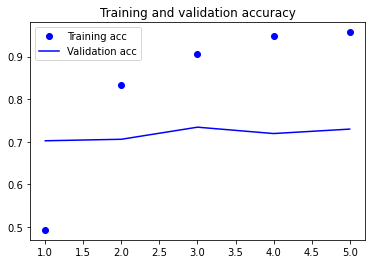

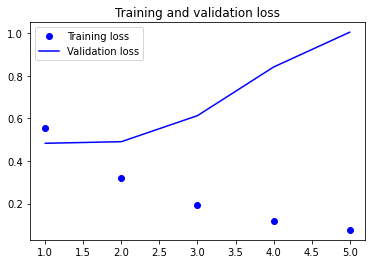

In [146]:
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [147]:
dependencies = {'get_f1': get_f1}

# load the model from disk
loaded_model_NN = keras.models.load_model('./NN.h5',custom_objects=dependencies)

In [148]:
# prediction on the test dataset
y_pred = (loaded_model_NN.predict(X_test) > 0.5).astype("int32")

In [149]:
# important metrices
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       874
           1       0.83      0.63      0.72       649

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523



In [155]:
# apply tokenizer on the test dataset
test_set = tokenizer.texts_to_matrix(test.text, mode = 'freq')

KeyError: ignored

In [156]:
# make predictions on the test dataset
y_test_pred = (loaded_model_NN.predict(test_set) > 0.5).astype("int32")

In [157]:
# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,1
2,3,0
3,9,1
4,11,1


In [158]:
sub.to_csv('prediction.csv',index=False)

#### Model 2

In [159]:
# Number of words to consider as features
max_features = vocab_size

# Cuts off the text after this number of words (among the max_features most common words)
maxlen = 100

# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(train.text)

# conver text to sequences
sequences = tokenizer.texts_to_sequences(train.text)

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen), padding shorter sequences with 0s
train_text = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

# Test train split 
X_train, X_test, y_train, y_test = train_test_split(train_text, train.target, test_size = 0.2, random_state = 42)

In [160]:
# build the model
model = Sequential()

# After the Embedding layer, the activations have shape (samples, maxlen, 8)
model.add(Embedding(vocab_size, 8, input_length=maxlen))

# Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())

# Dense layer for classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[get_f1])

callbacks_list = [EarlyStopping( monitor='get_f1', patience=1,), ModelCheckpoint(filepath='./embd.h5',monitor='val_loss',save_best_only=True)]

display(model.summary())

# train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 8)            48200     
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 801       
                                                                 
Total params: 49,001
Trainable params: 49,001
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5
153/153 [==============================] - 29s 186ms/step - loss: 0.6764 - get_f1: 0.0025 - val_loss: 0.6670 - val_get_f1: 0.2664
Epoch 2/5
153/153 [==============================] - 1s 4ms/step - loss: 0.6277 - get_f1: 0.3410 - val_loss: 0.6044 - val_get_f1: 0.6100


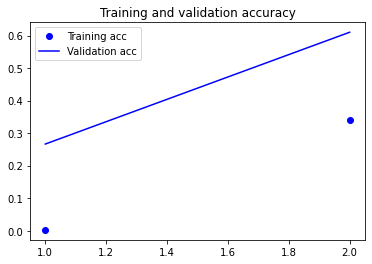

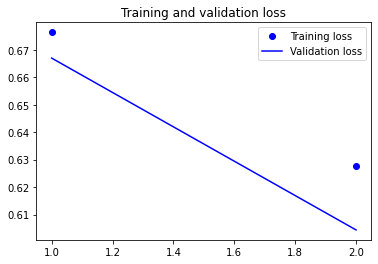

In [161]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [162]:
dependencies = {'get_f1': get_f1}

# load the model from disk
loaded_model_embd = keras.models.load_model('./embd.h5',custom_objects=dependencies)

In [163]:
# prediction on the test dataset
y_pred = (loaded_model_embd.predict(X_test) > 0.5).astype("int32")

# important metrices
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.92      0.80       874
           1       0.82      0.51      0.63       649

    accuracy                           0.74      1523
   macro avg       0.77      0.71      0.71      1523
weighted avg       0.76      0.74      0.73      1523



In [164]:
# conver text to sequences
sequences = tokenizer.texts_to_sequences(test.text)

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
test_text = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

In [165]:
# make predictions on the test dataset
y_test_pred = (loaded_model_embd.predict(test_text) > 0.5).astype("int32")

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [166]:
sub.to_csv('prediction.csv',index=False)

#### Model 3

In [167]:
# Considers only the top 5000 words in the dataset
max_words = 6000

In [169]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

callbacks_list = [EarlyStopping(monitor='get_f1', patience=1,), ModelCheckpoint(filepath='./SRNN.h5',monitor='val_loss',save_best_only=True)]

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[get_f1])

display(model.summary())

history = model.fit(X_train, y_train, epochs=100, batch_size=128, callbacks=callbacks_list, validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          192000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 194,113
Trainable params: 194,113
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5
39/39 [==============================] - 6s 82ms/step - loss: 0.6421 - get_f1: 0.3750 - val_loss: 0.6017 - val_get_f1: 0.4599
Epoch 2/5
39/39 [==============================] - 3s 79ms/step - loss: 0.4823 - get_f1: 0.7185 - val_loss: 0.5001 - val_get_f1: 0.7128


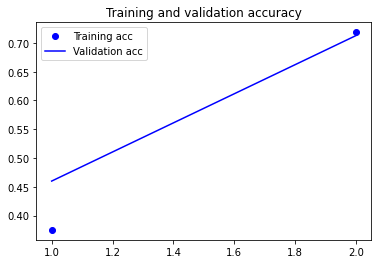

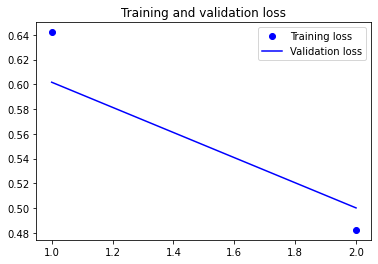

In [170]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [171]:
dependencies = {'get_f1': get_f1}

# load the model from disk
loaded_model_SRNN = keras.models.load_model('./SRNN.h5',custom_objects=dependencies)

In [172]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = (loaded_model_SRNN.predict(X_test) > 0.5).astype("int32")

# important metrices
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82       874
           1       0.80      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



In [173]:
# conver text to sequences
sequences = tokenizer.texts_to_sequences(test.text)

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
test_text = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

In [174]:
# make predictions on the test dataset
y_test_pred = (loaded_model_SRNN.predict(test_text) > 0.5).astype("int32")

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [175]:
sub.to_csv('prediction.csv',index=False)